In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import glob
import os
import functools
import itertools
import time
print("Running on ", time.asctime())

import numpy             as np
import scipy             as sci
import tables            as tb
import matplotlib.pyplot as plt
import math as math
import pandas as pd

import invisible_cities.io.hist_io as histio

from invisible_cities.io.pmaps_io      import load_pmaps
from invisible_cities.icaro.hst_functions    import shift_to_bin_centers
import icaro.core.pmaps_monitor_functions as monFun
from collections import defaultdict



Running on  Wed Feb 14 21:27:46 2018


In [2]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

In [3]:
rangeS1 = {'S1_Number': [0, 10, 10], 'S1_Width': [0, 1000, 40], 'S1_Height': [0, 10, 10], 'S1_Energy': [0, 50, 50],\
           'S1_Charge': [0, 20, 20], 'S1_Time': [0, 1300, 1300]} #Bin limits and number of bins
S1Bins = {attrName: [np.arange(attrVal[0], attrVal[1] + (attrVal[1]-attrVal[0]) / attrVal[2], (attrVal[1]-attrVal[0]) / attrVal[2]).tolist()]\
                        for attrName, attrVal in rangeS1.items()}

exception = ['S1_Energy', 'S1_Number']
for param in sorted(set(S1Bins.keys()).difference(exception)):
    S1Bins['S1_Energy_'+param] = [S1Bins['S1_Energy'][0], S1Bins[param][0]]



'''S2Var = {}
S2Var['Event'] = []
S2Var['Number'] = []
S2Var['Width'] = []
S2Var['Height'] = []
S2Var['Energy'] = []
S2Var['Time'] = []
S2Var['Timestamp'] = []
S2Var['OneS1'] = []

S2SiVar = {}
S2SiVar['Event'] = []
S2SiVar['Number'] = []
S2SiVar['Charge'] = []
S2SiVar['SiPM_MaxQ'] = []
S2SiVar['SiPM_Number'] = []
S2SiVar['SiPM_ID'] = []
S2SiVar['SiPM_Q'] = []
S2SiVar['SiPM_Timestamp'] = []
S2SiVar['Timestamp'] = []

RatioVar = {}
RatioVar['S2eS1e'] = []
RatioVar['S2S1t'] = []
RatioVar['S2SiqS2e'] = []

timestampEvent = []'''

"S2Var = {}\nS2Var['Event'] = []\nS2Var['Number'] = []\nS2Var['Width'] = []\nS2Var['Height'] = []\nS2Var['Energy'] = []\nS2Var['Time'] = []\nS2Var['Timestamp'] = []\nS2Var['OneS1'] = []\n\nS2SiVar = {}\nS2SiVar['Event'] = []\nS2SiVar['Number'] = []\nS2SiVar['Charge'] = []\nS2SiVar['SiPM_MaxQ'] = []\nS2SiVar['SiPM_Number'] = []\nS2SiVar['SiPM_ID'] = []\nS2SiVar['SiPM_Q'] = []\nS2SiVar['SiPM_Timestamp'] = []\nS2SiVar['Timestamp'] = []\n\nRatioVar = {}\nRatioVar['S2eS1e'] = []\nRatioVar['S2S1t'] = []\nRatioVar['S2SiqS2e'] = []\n\ntimestampEvent = []"

In [4]:
def hist_writer_var(file, *, compression = 'ZLIB4'):
    
    def write_hist(group_name  : 'options: HIST, HIST2D',
                   table_name  : 'histogram name',
                   entries     : 'np.array with bin content',
                   bins        : 'np.array of bins',
                   out_of_range: 'np.array lenght=2 with events out of range',
                   errors      : 'np.array with bins uncertainties'):
        
        try:                       hist_group = getattr          (file.root, group_name)
        except tb.NoSuchNodeError: hist_group = file.create_group(file.root, group_name)

        try:
            hist_table = getattr(hist_group, table_name)
        except tb.NoSuchNodeError:
            file.create_array(hist_group, table_name, entries)
#            file.create_vlarray(hist_group, table_name+'_bins', obj=bins)
            vlarray = file.create_vlarray(hist_group, table_name+'_bins', atom=tb.Float64Atom(shape=()))
            for ibin in bins:
#                print(ibin)
                vlarray.append(np.array(ibin))
            file.create_array(hist_group, table_name+'_outRange', out_of_range)
            file.create_array(hist_group, table_name+'_errors', errors)
                    
    return write_hist

In [5]:
class MonParam:
    def __init__(self, bins, values=None):
        """
        This class is a parameter holder that contains data grouped by bins.
        
        Attributes:
    
        bins     = Dictionary with the histogram binning. 
                   Keys refer to each parameter being saved, values are arrays.
        data     = Dictionary with the accumulated counts on each bin. 
                   Keys refer to each parameter being saved, values are arrays.
        outRange = Dictionary with the accumulated counts out of the bin range. 
                   Keys refer to each parameter being saved, values are n-dim arrays of lenght 2 (first element is
                   underflow, second oveflow).
        errors   = Dictionary with the assigned uncertanties to each bin. 
                   Keys refer to each parameter being saved, values are arrays.
    
        Arguments:
    
        bins   = Dictionary with the histogram binning. 
                 Keys refer to each parameter being saved, values are arrays.
        values = Dictionary of arrays with initial values, optional. 
                 If not passed, then the initial bin content is set to zero.
        """
        self.bins = bins
                
        self.data = {k: np.zeros(shape=[len(x)-1 for x in v]) for k, v in bins.items()}
        self.outRange = {k: np.zeros((2,)*len(v)) for k, v in bins.items()}
        self.errors = {k: np.zeros(shape=[len(x)-1 for x in v]) for k, v in bins.items()}
        if values:
            self.Add(values)       

    def Add(self, additive):
        """
        Given a dictionary holding data (keys are parameters, values is a list with the parameter values),
        bins it and adds it to the stored bin content.
        
        additive = Dictionary holding the data to fill the histogram.
        """
        for attribute, value in additive.items():
            binnedData, outRange = self.bin_data(np.asarray(value), self.bins[attribute])
            self.data[attribute] += binnedData
            self.outRange[attribute] += outRange
            self.update_errors() #Not sure if we want to update automatically as it would overlap previous setted errors
            
    def bin_data(self, data, histbins): 
        """
        Bins the given data and computes the events out of range.
        """
        binned_data = np.histogramdd(data, histbins)[0]
        out_of_range = [[len(data[i][data[i]<bins[0]]), len(data[i][data[i]>bins[-1]])] for i, bins in enumerate(histbins)]
        if len(histbins) == 1:
            out_of_range = out_of_range[0]
        return binned_data, out_of_range
    
    def update_errors(self, errors=None):
        """
        Updates the errors with the passed dictionary. If nothing is passed, then the 
        square root of the counts is computed and assigned as error.
        """        
        if errors:
            self.errors = errors
        else:
            self.errors = {k: np.sqrt(v) for k, v in self.data.items()}

In [6]:
def fillSvar (speaks, SVar, ptype):
    SVar[ptype + '_Number'].append(len(speaks))
    for speak in speaks:
        SVar[ptype + '_Width'] .append(speak.width)
        SVar[ptype + '_Height'].append(speak.height)
        SVar[ptype + '_Energy'].append(speak.total_energy)
        SVar[ptype + '_Charge'].append(speak.total_charge)
        SVar[ptype + '_Time']  .append(speak.time_at_max_energy)

In [7]:
def fill2D (SVar, ptype):
    SVar[ptype+'_Energy_'+ptype+'_Width'] = np.array([SVar[ptype+'_Energy'], SVar[ptype+'_Width']]).T

In [8]:
output = "/Users/ansimez/Documents/InvCit/hdf5/histos1_pmaps_001_4670_v0.9.3_20171128_double_kr1300.h5"
files = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/diffusion/4670/pmaps_00*_4670_v0.9.3_20171128_double_kr1300.h5")

SMon = MonParam(S1Bins)

for file in files[:1]:
    pmaps = load_pmaps(file)
    SVar = defaultdict(list)
    for i in pmaps:
        fillSvar(pmaps[i].s1s, SVar, 'S1')
    fill2D(SVar, 'S1')
    SMon.Add(SVar)
    
with tb.open_file(output, "w") as h5out:
    writer = hist_writer_var(h5out)    
    for param_name, bins in SMon.bins.items():    
        writer('HIST', param_name, SMon.data[param_name], bins, SMon.outRange[param_name], SMon.errors[param_name])

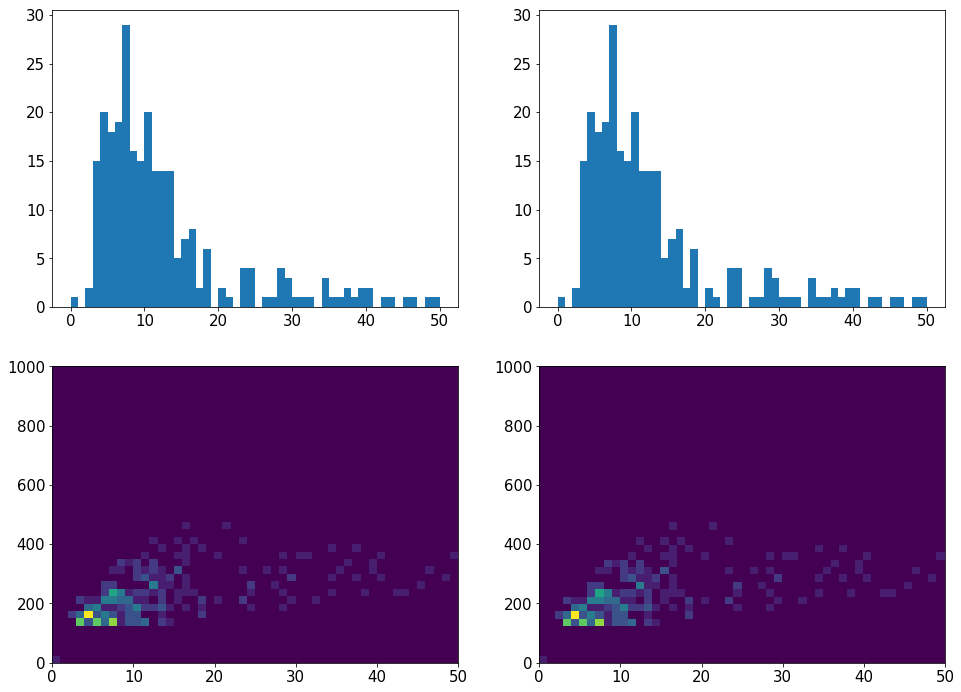

In [10]:
fig, axes = fig, ax = plt.subplots(2,2, figsize=(16, 12))
axes[0][0].hist(SVar['S1_Energy'], S1Bins['S1_Energy'][0])
axes[1][0].hist2d(SVar['S1_Energy'], SVar['S1_Width'], [S1Bins['S1_Energy'][0], S1Bins['S1_Width'][0]])


with tb.open_file(output, "r") as h5out:
    axes[0][1].bar(shift_to_bin_centers(h5out.root.HIST.S1_Energy_bins[0]), h5out.root.HIST.S1_Energy[:], width=np.diff(h5out.root.HIST.S1_Energy_bins[0]))
    axes[1][1].pcolormesh(h5out.root.HIST.S1_Energy_S1_Width_bins[0], h5out.root.HIST.S1_Energy_S1_Width_bins[1], h5out.root.HIST.S1_Energy_S1_Width[:].T)